## Byron Dennis - Final Project

### Overview

I recently applied for a data scientist position at a company in the KC metro area.  After the initial interview the company asked me to complete a project to see if I was truly capable enough for the job.  The notebook below is a modified version of what I provided to the company.

#### This data presented new challeneges for me.
1. Inconsistent data types between the train/test set and the holdout set.
2. Unknown data formats (birthdate was an excel date value rather than a date)
3. Erroneous data (some zip codes were not 5 digits & ages were negative)
4. Needed to ensure the data transformation on the train/test set were applied consistently to the holdout set.
5. Had to predict values out onto a new data set rather than just training a model.
6. AUC was specifically requested as the preferred metric.

I was asked to complete this test on a Wednesday just before class and the due date was the following Monday.  I worked on this project at the same time that homework 2 was due and my job was requiring more hours than usual.  I submitted the file back to the company at midnight on the due date.  I received a call back and have a final interview scheduled.

## Assignment provided by the company

Your goal is to build a model which will predict the "target" variable. The "target" in this case is whether or not a person has purchased something. Attached are two files: 1) one is for training and testing, and 2) the other is the holdout submission set. You should build the best model possible in order to maximize the area under the receiver operating characteristic curve (ROC AUC). ROC AUC should be your scoring parameter. 

## Import standard packages

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection  import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

## Import data

In [51]:
#set file path
path='c:/Users/byron/Desktop/SVG/data/'

#reading in train_test and holdout.  All processing performed for "train_test" must also be applied to "holdout" 
train_df=pd.read_csv(path + 'train_test.csv')
holdout_df=pd.read_csv(path + 'holdout.csv')

print(train_df.shape)
print(holdout_df.shape)

(137804, 11)
(34178, 10)


- There are 137,804 records and 11 columns in the train_test data frame.  One column is the Target which will not be found on the holdout set.

- There are 34,178 records and 10 columns in the holdout data frame.

## Data Preparation

1. These fields have formatting differences between the two data sets.
     - Created Date Time (not sure what value this field would provide to this analysis)
     - Birthdate
2. Applicant City does not have a consistent case.  It would probably be better to aggregate the location data to region, state, or 3-digit zip.  If time allows mapping zip code to census data may be beneficial to finding income differences.
3. Need to make sure lead source and Neustar Result Code are considered a categories rather than a continuous variables.
4. System ID may have some valuable information related to the encounter with the customer, but for this exercise it will be dropped. 

In [52]:
train_df.head()

,System ID,Created Date Time,Neustar Result Code,Lead Source,Emails,Birthdate,Gender,Applicant State/Province,Applicant Zip/Postal Code,Applicant City,target
0,00Qd000000pILTKEA4,9/1/2016,3.0,80,NaN,15316.0,Female,OH,45230,Cincinnati,NaN
1,00Qd000000pILTxEAO,9/1/2016,10.0,114,NaN,17863.0,Female,AZ,85122,Casa Grande,NaN
2,00Qd000000pILU7EAO,9/1/2016,10.0,6,NaN,18099.0,Male,NV,89110,Las Vegas,NaN
3,00Qd000000pILUHEA4,9/1/2016,10.0,81,NaN,16078.0,Male,OK,73507,Lawton,NaN
4,00Qd000000pILUREA4,9/1/2016,7.0,81,NaN,17053.0,Female,NV,89523,Reno,NaN


In [53]:
holdout_df.head()

,System ID,Created Date Time,Neustar Result Code,Lead Source,Emails,Birthdate,Gender,Applicant State/Province,Applicant Zip/Postal Code,Applicant City
0,00Qd000000q7hjDEAQ,9/16/2016 13:23,10.0,85,NaN,9/21/1943,Female,TX,75901,Lufkin
1,00Qd000000pHFGPEA4,9/8/2016 21:21,5.0,102,2.0,10/15/1948,Female,PA,15613,Apollo
2,00Qd000000q8h9WEAQ,9/28/2016 15:23,7.0,25,NaN,7/24/1951,Male,GA,30474,Vidalia
3,00Qd000000r5f5TEAQ,10/1/2016 23:25,10.0,80,1.0,11/20/1951,Male,AZ,85748,Tucson
4,00Qd000000pIkMQEA0,9/8/2016 7:32,10.0,4,NaN,2/2/1952,Female,OH,43154,Stoutsville


## Data set tail

In [54]:
#train_df.tail()

In [55]:
#holdout_df.tail()

#### Seeing variation in data types between files.  Also noticing some variation in the way the data was input.

In [56]:
#Review data types for train_test
train_df.dtypes

System ID                     object
Created Date Time             object
Neustar Result Code          float64
Lead Source                    int64
Emails                       float64
Birthdate                    float64
Gender                        object
Applicant State/Province      object
Applicant Zip/Postal Code     object
Applicant City                object
target                       float64
dtype: object

In [57]:
#Review data types for holdout
holdout_df.dtypes

System ID                     object
Created Date Time             object
Neustar Result Code          float64
Lead Source                    int64
Emails                       float64
Birthdate                     object
Gender                        object
Applicant State/Province      object
Applicant Zip/Postal Code     object
Applicant City                object
dtype: object

## Convert birthdate to Age for both files
Rather than using birthdate as my column I feel it would be better to convert the column to age and possibly create bins.

### Define functions to format birthdate and calculate age.

In [58]:
#After researching it appears the numeric date values are excel date values.  Need to convert this to date.
#Date conversion function
import datetime
def xldate_to_datetime(xldate):
    try:
        xls_early_dt = datetime.datetime(1900, 1, 1)
        delta = datetime.timedelta(days=xldate)
        return pd.to_datetime(xls_early_dt+delta)
    except:
        return ''

#there may be some leap year issues with the date calc, but should be close enough.

#I will also need a function to convert bday to age.
from datetime import date
def calc_age(bday):
    try:
        today = date.today()
        age = today.year - bday.year - ((today.month, today.day) < (bday.month, bday.day))
        return age
    except:
        return ''

In [59]:
#Convert birthdate in train_test
train_df.Birthdate = train_df.Birthdate.apply(xldate_to_datetime)

#Convert birthdate in holdout to correct format
holdout_df.Birthdate = pd.to_datetime(holdout_df.Birthdate)

#Create new Age columns
train_df['Age'] = train_df.Birthdate.apply(calc_age)
holdout_df['Age'] = holdout_df.Birthdate.apply(calc_age)

In [60]:
#Check to see that new columns were added as expected
train_df.head(2)

,System ID,Created Date Time,Neustar Result Code,Lead Source,Emails,Birthdate,Gender,Applicant State/Province,Applicant Zip/Postal Code,Applicant City,target,Age
0,00Qd000000pILTKEA4,9/1/2016,3.0,80,NaN,1941-12-08,Female,OH,45230,Cincinnati,NaN,76.0
1,00Qd000000pILTxEAO,9/1/2016,10.0,114,NaN,1948-11-28,Female,AZ,85122,Casa Grande,NaN,69.0


In [61]:
#holdout_df.head(2)

In [62]:
#Check statistics on new Age columns
train_df.Age.describe()

count    132437.000000
mean         69.041189
std           9.404198
min         -13.000000
25%          66.000000
50%          69.000000
75%          73.000000
max          87.000000
Name: Age, dtype: float64

In [63]:
#holdout_df.Age.describe()

## Combine data sets

Predict function will not work as expected if columns are not consistent between both sets.  To mitigate this problem I am combining both the train and holdout sets while creating dummies and other transformations.

In [64]:
train_df['label'] = 'train'
holdout_df['label'] = 'holdout'
concat_df = pd.concat([train_df , holdout_df])
concat_df.head()

,Age,Applicant City,Applicant State/Province,Applicant Zip/Postal Code,Birthdate,Created Date Time,Emails,Gender,Lead Source,Neustar Result Code,System ID,label,target
0,76.0,Cincinnati,OH,45230,1941-12-08,9/1/2016,NaN,Female,80,3.0,00Qd000000pILTKEA4,train,NaN
1,69.0,Casa Grande,AZ,85122,1948-11-28,9/1/2016,NaN,Female,114,10.0,00Qd000000pILTxEAO,train,NaN
2,68.0,Las Vegas,NV,89110,1949-07-22,9/1/2016,NaN,Male,6,10.0,00Qd000000pILU7EAO,train,NaN
3,73.0,Lawton,OK,73507,1944-01-09,9/1/2016,NaN,Male,81,10.0,00Qd000000pILUHEA4,train,NaN
4,71.0,Reno,NV,89523,1946-09-10,9/1/2016,NaN,Female,81,7.0,00Qd000000pILUREA4,train,NaN


#### Notes about new Age columns
1. min age is -13.  These are erroneous entries
2. avg age is 69 w/ std of 9.  The data set is primarily seniors so children and young adults are likely errors as well
3. the train_test statistics are surprisingly similar which raises a flag.  Need to check calculations.

#### Reviewed DFs and birthdate/age columns appear to be functioning correctly.

In [65]:
#count number of records where age is less than 21
child_cnt=concat_df.Age.loc[concat_df['Age'] < 21].count()

print('Count of records where age < 21: ',child_cnt)

Count of records where age < 21:  1408


#### Less than 1% of the records have an age < 21.  Going to replace these age values with Nan for now and will revew further.

In [66]:
#Need to convert dtype to float from object for calculation to work.
concat_df.Age=pd.to_numeric(concat_df.Age)

concat_df.dtypes

Age                                 float64
Applicant City                       object
Applicant State/Province             object
Applicant Zip/Postal Code            object
Birthdate                    datetime64[ns]
Created Date Time                    object
Emails                              float64
Gender                               object
Lead Source                           int64
Neustar Result Code                 float64
System ID                            object
label                                object
target                              float64
dtype: object

In [67]:
#replace Age < 21 with NaN
concat_df.Age.loc[concat_df['Age'] < 21] = None

C:\Users\byron\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Check missing values

In [68]:
concat_df.isnull().sum().sort_values(ascending=False)

target                       160855
Emails                       153304
Gender                        47164
Applicant City                39664
Neustar Result Code           11555
Age                            8090
Birthdate                      6682
Applicant State/Province       1328
Applicant Zip/Postal Code      1207
label                             0
System ID                         0
Lead Source                       0
Created Date Time                 0
dtype: int64

#### Missing Values Notes
1. Every column has missing values except Lead Source, Created Date Time, and System ID.
2. Emails is a count.  When email is 0 the field is left blank.  Going to replace all email NaN with 0.  NaN's may be mislabled as 0 in some cases.
3. A significant number of records are missing for Gender as well, but this could be a key value.  I will check the distribution of this field and consider imputing a value.
4. Neustar needs additional review to determine how to handle.
5. Age will be imputed w/ median.  Counts do not equal birthdate.  This is because the birthdate column uses NaT for some errors.
5. Possible entire records should be dropped if there are too many missing columns.

#### Replace email NaN w/ 0

In [69]:
#replace Email NaN with 0
#some Email values may have been missing rather than 0.
concat_df.Emails.loc[concat_df.Emails.isnull()] = 0
concat_df.head()

C:\Users\byron\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Age,Applicant City,Applicant State/Province,Applicant Zip/Postal Code,Birthdate,Created Date Time,Emails,Gender,Lead Source,Neustar Result Code,System ID,label,target
0,76.0,Cincinnati,OH,45230,1941-12-08,9/1/2016,0.0,Female,80,3.0,00Qd000000pILTKEA4,train,NaN
1,69.0,Casa Grande,AZ,85122,1948-11-28,9/1/2016,0.0,Female,114,10.0,00Qd000000pILTxEAO,train,NaN
2,68.0,Las Vegas,NV,89110,1949-07-22,9/1/2016,0.0,Male,6,10.0,00Qd000000pILU7EAO,train,NaN
3,73.0,Lawton,OK,73507,1944-01-09,9/1/2016,0.0,Male,81,10.0,00Qd000000pILUHEA4,train,NaN
4,71.0,Reno,NV,89523,1946-09-10,9/1/2016,0.0,Female,81,7.0,00Qd000000pILUREA4,train,NaN


#### Replace Age NaN w/ median

In [70]:
#replace missing values for Age by imputing the median
concat_df.Age.loc[concat_df.Age.isnull()] = concat_df.Age.median()
concat_df.head()

C:\Users\byron\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Age,Applicant City,Applicant State/Province,Applicant Zip/Postal Code,Birthdate,Created Date Time,Emails,Gender,Lead Source,Neustar Result Code,System ID,label,target
0,76.0,Cincinnati,OH,45230,1941-12-08,9/1/2016,0.0,Female,80,3.0,00Qd000000pILTKEA4,train,NaN
1,69.0,Casa Grande,AZ,85122,1948-11-28,9/1/2016,0.0,Female,114,10.0,00Qd000000pILTxEAO,train,NaN
2,68.0,Las Vegas,NV,89110,1949-07-22,9/1/2016,0.0,Male,6,10.0,00Qd000000pILU7EAO,train,NaN
3,73.0,Lawton,OK,73507,1944-01-09,9/1/2016,0.0,Male,81,10.0,00Qd000000pILUHEA4,train,NaN
4,71.0,Reno,NV,89523,1946-09-10,9/1/2016,0.0,Female,81,7.0,00Qd000000pILUREA4,train,NaN


#### Drop columns not adding value

In [71]:
#Drop System ID, Created Date Time, Applicant City and Birthdate, Appliicant Zip/Postal Code.  
#These fields have information captured in other columns or do not provide valueable information.

concat_df=concat_df.drop(['System ID','Created Date Time','Applicant City','Birthdate','Applicant Zip/Postal Code'],axis=1)

#Note:A random forest was used to see if 3-digit zip had more signal than state.
#State had more importance in the random forest so the decision was made to drop zip code. 

print(concat_df.shape)

(171982, 8)


In [72]:
concat_df.head()

,Age,Applicant State/Province,Emails,Gender,Lead Source,Neustar Result Code,label,target
0,76.0,OH,0.0,Female,80,3.0,train,NaN
1,69.0,AZ,0.0,Female,114,10.0,train,NaN
2,68.0,NV,0.0,Male,6,10.0,train,NaN
3,73.0,OK,0.0,Male,81,10.0,train,NaN
4,71.0,NV,0.0,Female,81,7.0,train,NaN


In [73]:
#Check the results of Age and Email changes.
#concat_df.describe()

In [74]:
#What else is missing
#concat_df.isnull().sum().sort_values(ascending=False)


Gender is fairly balanced, but some entries are inconsistently labeled.


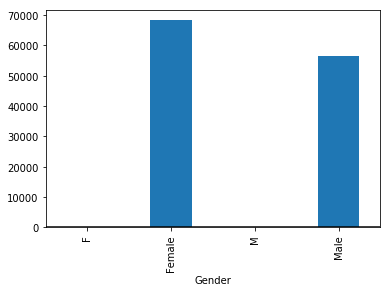

In [75]:
#Check distribution of Gender to determine best way to fill missing
groupby = concat_df.groupby(['Gender'])
plt.figure()
groupby['Gender'].aggregate(len).plot(kind='bar', grid=False)
plt.axhline(0, color='k')
print()
print("Gender is fairly balanced, but some entries are inconsistently labeled.")

#### Gender dummies

In [76]:
#Code missing genders as 'UNK' because the dataset has a fairly balanced Gender column.

#Convert Female to 'F' and Male to 'M'.  These will be encoded later.
concat_df.Gender.loc[train_df['Gender']=='Female'] = 'F'
concat_df.Gender.loc[train_df['Gender']=='Male'] = 'M'

#Create Gender Dummies
gender_dummy = pd.get_dummies(concat_df['Gender'], prefix='Gender', dummy_na=True)

#Concat Gender Dummies
concat_df = pd.concat([concat_df,gender_dummy], axis=1)

#drop original column
del concat_df['Gender']

C:\Users\byron\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [77]:
concat_df.head()

,Age,Applicant State/Province,Emails,Lead Source,Neustar Result Code,label,target,Gender_F,Gender_Female,Gender_M,Gender_Male,Gender_nan
0,76.0,OH,0.0,80,3.0,train,NaN,1,0,0,0,0
1,69.0,AZ,0.0,114,10.0,train,NaN,1,0,0,0,0
2,68.0,NV,0.0,6,10.0,train,NaN,0,0,1,0,0
3,73.0,OK,0.0,81,10.0,train,NaN,0,0,1,0,0
4,71.0,NV,0.0,81,7.0,train,NaN,1,0,0,0,0


In [78]:
#What else is missing
concat_df.isnull().sum().sort_values(ascending=False)

target                      160855
Neustar Result Code          11555
Applicant State/Province      1328
Gender_nan                       0
Gender_Male                      0
Gender_M                         0
Gender_Female                    0
Gender_F                         0
label                            0
Lead Source                      0
Emails                           0
Age                              0
dtype: int64

#### State Dummies

In [79]:
#No clear category to missing values.

#Create Dummies
dummy = pd.get_dummies(concat_df['Applicant State/Province'], prefix='STATE', dummy_na=True)

#Concat Gender Dummies
concat_df = pd.concat([concat_df,dummy], axis=1)

#drop original column
del concat_df['Applicant State/Province']

#concat_df.head()

In [80]:
concat_df['Neustar Result Code'].value_counts(dropna=False)

 10.0    109951
 1.0      15554
 7.0      14004
 5.0      13862
NaN       11555
 3.0       6473
 0.0        583
Name: Neustar Result Code, dtype: int64

#### Neustar dummies

In [81]:
#No clear category to missing values.  Code Neustar Nan as UNK

#Create Dummies
dummy = pd.get_dummies(concat_df['Neustar Result Code'], prefix='Neustar', dummy_na=True)

#Concat Gender Dummies
concat_df = pd.concat([concat_df,dummy], axis=1)

#drop original column
del concat_df['Neustar Result Code']

concat_df.head()

,Age,Emails,Lead Source,label,target,Gender_F,Gender_Female,Gender_M,Gender_Male,Gender_nan,...,STATE_WV,STATE_WY,STATE_nan,Neustar_0.0,Neustar_1.0,Neustar_3.0,Neustar_5.0,Neustar_7.0,Neustar_10.0,Neustar_nan
0,76.0,0.0,80,train,NaN,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,69.0,0.0,114,train,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,68.0,0.0,6,train,NaN,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,73.0,0.0,81,train,NaN,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,71.0,0.0,81,train,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [82]:
#concat_df['Lead Source'].value_counts(dropna=False).head()

## Lead Source Dummies

In [83]:
#Create dummies Lead Source.  Determined that Lead Source 113 was the only lead source correlated to the target.

#Create Dummies
dummy = pd.get_dummies(concat_df['Lead Source'], prefix='Lead', dummy_na=True)

#Concat Dummies
concat_df = pd.concat([concat_df, dummy], axis=1)

#drop original column
del concat_df['Lead Source']

concat_df.head()

,Age,Emails,label,target,Gender_F,Gender_Female,Gender_M,Gender_Male,Gender_nan,STATE_AK,...,Lead_179.0,Lead_180.0,Lead_181.0,Lead_182.0,Lead_183.0,Lead_184.0,Lead_185.0,Lead_186.0,Lead_187.0,Lead_nan
0,76.0,0.0,train,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,69.0,0.0,train,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68.0,0.0,train,NaN,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,73.0,0.0,train,NaN,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,71.0,0.0,train,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Normalize Columns

In [84]:
#Normalize Age and Emails.  Going to use min/max scale so the values are within the same range as dummies.

concat_df.Age = (concat_df.Age - concat_df.Age.min(axis=0)) / (concat_df.Age.max(axis=0) - concat_df.Age.min(axis=0))
concat_df.Emails = (concat_df.Emails - concat_df.Emails.min(axis=0)) / (concat_df.Emails.max(axis=0) - concat_df.Emails.min(axis=0))

#check transformations
concat_df.Age.describe()
concat_df.Emails.describe()

count    171982.000000
mean          0.012349
std           0.041464
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Emails, dtype: float64

## Split Data Sets

In [85]:
#split files
train_df = concat_df[concat_df['label'] == 'train']
holdout_df = concat_df[concat_df['label'] == 'holdout']

#drop labels
train_df = train_df.drop('label', axis=1)
holdout_df = holdout_df.drop('label', axis=1)
holdout_df = holdout_df.drop('target',axis=1)

#check results
train_df.head()

,Age,Emails,target,Gender_F,Gender_Female,Gender_M,Gender_Male,Gender_nan,STATE_AK,STATE_AL,...,Lead_179.0,Lead_180.0,Lead_181.0,Lead_182.0,Lead_183.0,Lead_184.0,Lead_185.0,Lead_186.0,Lead_187.0,Lead_nan
0,0.833333,0.0,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.727273,0.0,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.712121,0.0,NaN,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.787879,0.0,NaN,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.757576,0.0,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
#check holdout set
holdout_df.head()

,Age,Emails,Gender_F,Gender_Female,Gender_M,Gender_Male,Gender_nan,STATE_AK,STATE_AL,STATE_AR,...,Lead_179.0,Lead_180.0,Lead_181.0,Lead_182.0,Lead_183.0,Lead_184.0,Lead_185.0,Lead_186.0,Lead_187.0,Lead_nan
0,0.803030,0.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.727273,0.166667,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.681818,0.000000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.681818,0.083333,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.666667,0.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Check Target Distribution

## Replace Target NaN w/ 0

In [87]:
#replace target NaN with 0
train_df.target.loc[train_df['target'].isnull()] = 0
train_df.tail()

C:\Users\byron\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Age,Emails,target,Gender_F,Gender_Female,Gender_M,Gender_Male,Gender_nan,STATE_AK,STATE_AL,...,Lead_179.0,Lead_180.0,Lead_181.0,Lead_182.0,Lead_183.0,Lead_184.0,Lead_185.0,Lead_186.0,Lead_187.0,Lead_nan
137799,0.681818,0.0,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137800,0.818182,0.0,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137801,0.712121,0.0,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137802,0.803030,0.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137803,0.696970,0.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Move target to first position of table.

In [88]:
# Move target to first position.
# designate target variable name
targetName = 'target'
targetSeries = train_df[targetName]
#remove target from current location and insert in collum 0
del train_df[targetName]
train_df.insert(0, targetName, targetSeries)
#reprint dataframe and see target is in position 0
train_df.head(1)

,target,Age,Emails,Gender_F,Gender_Female,Gender_M,Gender_Male,Gender_nan,STATE_AK,STATE_AL,...,Lead_179.0,Lead_180.0,Lead_181.0,Lead_182.0,Lead_183.0,Lead_184.0,Lead_185.0,Lead_186.0,Lead_187.0,Lead_nan
0,0.0,0.833333,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Target Percent Distribution
target
0.0    0.919255
1.0    0.080745
Name: target, dtype: float64

Target Distribution
target
0.0    126677.0
1.0     11127.0
Name: target, dtype: float64



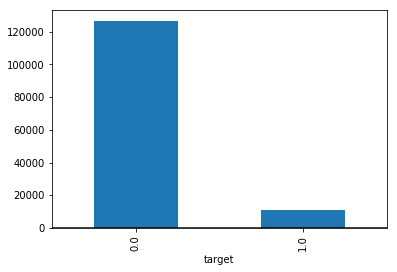

In [89]:
#Basic bar chart since the target is binominal
groupby = train_df.groupby(targetName) #target name defined in above section.
targetEDA=groupby[targetName].aggregate(len)
plt.figure()
targetEDA.plot(kind='bar', grid=False)
plt.axhline(0, color='k')
print("Target Percent Distribution")
print(targetEDA / len(train_df.index))
print()
print("Target Distribution")
print(targetEDA)
print()

The dataset is imbalanced.  92% of customers have not made a purchase.  It may be necessary to try sampling techniques (upsampling/downsampling, KNN imputations, etc).

## Create test train split 40/60 for feature selection phase

In [90]:
#Test Train Split 40/60
from sklearn.model_selection  import train_test_split, cross_val_score, KFold

X_train, X_test, y_train, y_test = train_test_split(
    train_df.iloc[:,1:].values, train_df.iloc[:,0].values, test_size=0.60, random_state=1)

#confirm rows and column counts are as expected
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(55121, 255)
(55121,)
(82683, 255)
(82683,)


## Use random forest to identify important features

In [91]:
#Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#call up the model
clf_RF1 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=123)
#Fit clf to the training data
clf_RF1 = clf_RF1.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_RF1 = clf_RF1.predict(X_test)

#print metrics

print()
print("Random Forest Accuracy Score", accuracy_score(y_test, y_pred_RF1))
print(classification_report(y_test, y_pred_RF1))
print(confusion_matrix(y_test, y_pred_RF1))
roc_auc_score(y_test, y_pred_RF1, sample_weight=None)


Random Forest Accuracy Score 0.91032013836
             precision    recall  f1-score   support

        0.0       0.93      0.97      0.95     76018
        1.0       0.40      0.22      0.28      6665

avg / total       0.89      0.91      0.90     82683

[[73812  2206]
 [ 5209  1456]]


0.5947175854449287

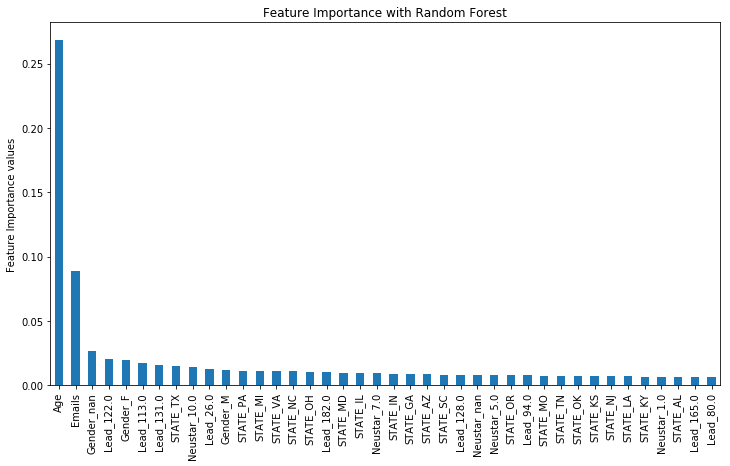

In [92]:
imp_feat_rf = pd.Series(clf_RF1.feature_importances_, index=train_df.iloc[: , 1:].columns).sort_values(ascending=False)
imp_feat_rf[:40].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('FeatImportance.png')
plt.show()

#### Top Important features
- Age
- Emails
- Gender
- Lead Source 122, 113, and 131
- State is Texas
- Neustar Code 10

## Try balanced class weight to see if important features change

In [93]:
#Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#call up the model
clf_RF2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=123)
#Fit clf to the training data
clf_RF2 = clf_RF2.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_RF2 = clf_RF2.predict(X_test)

#print metrics

print()
print("Random Forest Accuracy Score", accuracy_score(y_test, y_pred_RF2))
print(classification_report(y_test, y_pred_RF2))
print(confusion_matrix(y_test, y_pred_RF2))
roc_auc_score(y_test, y_pred_RF2, sample_weight=None)


Random Forest Accuracy Score 0.89356941572
             precision    recall  f1-score   support

        0.0       0.93      0.95      0.94     76018
        1.0       0.30      0.24      0.27      6665

avg / total       0.88      0.89      0.89     82683

[[72258  3760]
 [ 5040  1625]]


0.59717449160232661

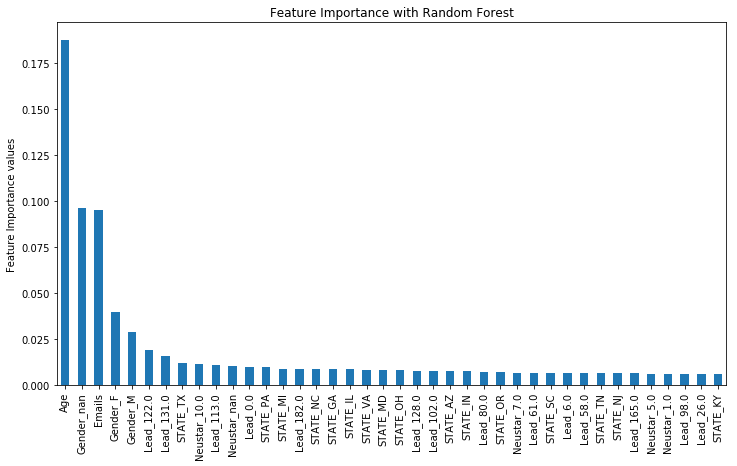

In [94]:
imp_feat_rf = pd.Series(clf_RF2.feature_importances_, index=train_df.iloc[: , 1:].columns).sort_values(ascending=False)
imp_feat_rf[:40].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('FeatImportance.png')
plt.show()

Important features did not change, but the importance of key features is represented differently.

# Begin Modeling Process

## Create test train split 70/30

In [95]:
#Test Train Split 70/30
from sklearn.model_selection  import train_test_split, cross_val_score, KFold

X_train, X_test, y_train, y_test = train_test_split(
    train_df.iloc[:,1:].values, train_df.iloc[:,0].values, test_size=0.30, random_state=1)

#confirm rows and column counts are as expected
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(96462, 255)
(96462,)
(41342, 255)
(41342,)


## Logistic Regressions

Using penalty on models to reduce dimensions

## Logistic Regression

In [96]:
from sklearn.linear_model import LogisticRegression
print(LogisticRegression())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [97]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
#Fit to the training data
log = log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print("Accuracy Score", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

roc_auc_score(y_test, y_pred)

Accuracy Score 0.923129021334
             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96     37990
        1.0       0.59      0.17      0.26      3352

avg / total       0.90      0.92      0.90     41342

[[37606   384]
 [ 2794   558]]


0.57817992864596324

## Logistic Regression w/ Ridge (l2), C=100

In [103]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(penalty='l2', solver='lbfgs', n_jobs=-1, C=100)
#Fit to the training data
log = log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print("Accuracy Score", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

roc_auc_score(y_test, y_pred)

Accuracy Score 0.923395094577
             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96     37990
        1.0       0.59      0.18      0.27      3352

avg / total       0.90      0.92      0.90     41342

[[37580   410]
 [ 2757   595]]


0.58335682641016573

## Logistic Regression w/ Lasso (l1) penalty C=100

In [102]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1, C=100)
#Fit to the training data
log = log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print("Accuracy Score", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

roc_auc_score(y_test, y_pred)

Accuracy Score 0.923395094577
             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96     37990
        1.0       0.59      0.18      0.27      3352

avg / total       0.90      0.92      0.90     41342

[[37579   411]
 [ 2756   596]]


C:\Users\byron\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.58349282972971794

## Decision Tree Model (default)

Initial model w/ out of the box settings.  Precision for minority class is .34 and recall is .26.  Needs a lot of improvement.

In [143]:
#Decision Tree train model. Call up my model and name it clf
from sklearn import tree 
clf_dt = tree.DecisionTreeClassifier(random_state=123)
#Call up the model to see the parameters you can tune (and their default setting)
print(clf_dt)
#Fit clf to the training data
clf_dt = clf_dt.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_dt = clf_dt.predict(X_test)

#print metrics

print()
print("Decision Accuracy Score", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

roc_auc_score(y_test, y_pred_dt, sample_weight=None)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

Decision Accuracy Score 0.900149968555
             precision    recall  f1-score   support

        0.0       0.94      0.96      0.95     37990
        1.0       0.34      0.26      0.29      3352

avg / total       0.89      0.90      0.89     41342

[[36359  1631]
 [ 2497   855]]


0.60606962421338106

## Decision Tree (class_weight = 'balanced')

In [144]:
#Decision Tree train model.
from sklearn import tree 
#call up the model
clf_dt2 = tree.DecisionTreeClassifier(class_weight='balanced', random_state=123)
#Fit clf to the training data
clf_dt2 = clf_dt2.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_dt2 = clf_dt2.predict(X_test)

#print metrics

print()
print("Decision Accuracy Score", accuracy_score(y_test, y_pred_dt2))
print(classification_report(y_test, y_pred_dt2))
print(confusion_matrix(y_test, y_pred_dt2))
roc_auc_score(y_test, y_pred_dt2)


Decision Accuracy Score 0.851869769242
             precision    recall  f1-score   support

        0.0       0.94      0.89      0.92     37990
        1.0       0.24      0.39      0.30      3352

avg / total       0.89      0.85      0.87     41342

[[33913  4077]
 [ 2047  1305]]


0.64100104694050253

# Best Model for AUC (.74)

## Decision Tree (class_weight = 'balanced', max_depth=6)

In [104]:
#Decision Tree train model.
from sklearn import tree 
#call up the model
clf_dt3 = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=123)
#Fit clf to the training data
clf_dt3 = clf_dt3.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_dt3 = clf_dt3.predict(X_test)

#print metrics

print()
print("Decision Accuracy Score", accuracy_score(y_test, y_pred_dt3))
print(classification_report(y_test, y_pred_dt3))
print(confusion_matrix(y_test, y_pred_dt3))
roc_auc_score(y_test, y_pred_dt3, sample_weight=None)


Decision Accuracy Score 0.855570606163
             precision    recall  f1-score   support

        0.0       0.96      0.88      0.92     37990
        1.0       0.30      0.60      0.40      3352

avg / total       0.91      0.86      0.88     41342

[[33345  4645]
 [ 1326  2026]]


0.74107312815016635

#### Cross validation shows model has consistent results.

In [146]:
#Cross Validate Best Model
clf_dt3_scores = cross_val_score(clf_dt3, X_train, y_train, cv=10)
print("Cross Validation Score for each K - clf_dt3", clf_dt3_scores)
print("Decision Tree mean:", clf_dt3_scores.mean())  
print()

Cross Validation Score for each K - clf_dt3 [ 0.85363325  0.86379185  0.85290764  0.85373691  0.85415155  0.85195936
  0.85465478  0.85598756  0.85370658  0.84955936]
Decision Tree mean: 0.854408884846



## Random Forest (500 trees)

Poor performance for this model as well.

In [147]:
#Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#call up the model
clf_RF1 = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=123)
print(clf_RF1)
#Fit clf to the training data
clf_RF1 = clf_RF1.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_RF1 = clf_RF1.predict(X_test)


#print metrics

print()
print("Random Forest Accuracy Score", accuracy_score(y_test, y_pred_RF1))
print(classification_report(y_test, y_pred_RF1))
print(confusion_matrix(y_test, y_pred_RF1))
roc_auc_score(y_test, y_pred_RF1, sample_weight=None)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

Random Forest Accuracy Score 0.911397610179
             precision    recall  f1-score   support

        0.0       0.93      0.97      0.95     37990
        1.0       0.42      0.23      0.29      3352

avg / total       0.89      0.91      0.90     41342

[[36914  1076]
 [ 2587   765]]


0.59994935704094976

## AdaBoost (200 trees)

In [148]:
#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
#call up the model
bdt1 = AdaBoostClassifier(DecisionTreeClassifier(),
                          n_estimators=200, random_state=123)

#Fit clf to the training data
bdt1 = bdt1.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_bdt1 = bdt1.predict(X_test)

#print metrics

print()
print("Accuracy Score", accuracy_score(y_test, y_pred_bdt1))
print(classification_report(y_test, y_pred_bdt1))
print(confusion_matrix(y_test, y_pred_bdt1))
roc_auc_score(y_test, y_pred_bdt1)


Accuracy Score 0.902133423637
             precision    recall  f1-score   support

        0.0       0.94      0.96      0.95     37990
        1.0       0.35      0.25      0.29      3352

avg / total       0.89      0.90      0.89     41342

[[36471  1519]
 [ 2527   825]]


0.60306875600349541

## Bagging (200 trees)

91% Accuracy, 0.41 precision, 0.14 recall

In [149]:
from sklearn.ensemble import BaggingClassifier
print(BaggingClassifier())

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)


In [105]:
#Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#call up the model
bag1 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=200 , n_jobs=-1 ,random_state=123)
#Fit clf to the training data
bag1 = bag1.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_bag1 = bag1.predict(X_test)

#print metrics

print()
print("Accuracy Score", accuracy_score(y_test, y_pred_bag1))
print(classification_report(y_test, y_pred_bag1))
print(confusion_matrix(y_test, y_pred_bag1))
roc_auc_score(y_test, y_pred_bag1)


Accuracy Score 0.908567558415
             precision    recall  f1-score   support

        0.0       0.94      0.97      0.95     37990
        1.0       0.40      0.25      0.31      3352

avg / total       0.89      0.91      0.90     41342

[[36726  1264]
 [ 2516   836]]


0.60806571381364649

## Bagging (200 trees, max_samples .8, class_weight='balanced')

Overall accuracy increased, but recall is near 0% for target.

In [106]:
#Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#call up the model
bag2 = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'), 
                         n_estimators=200, 
                         max_samples=.8,
                         bootstrap_features=False,
                         n_jobs=-1 ,
                         random_state=123)

#Fit clf to the training data
bag2 = bag2.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_bag2 = bag2.predict(X_test)

#print metrics

print()
print("Accuracy Score", accuracy_score(y_test, y_pred_bag2))
print(classification_report(y_test, y_pred_bag2))
print(confusion_matrix(y_test, y_pred_bag2))
roc_auc_score(y_test, y_pred_bag2)


Accuracy Score 0.891635624788
             precision    recall  f1-score   support

        0.0       0.94      0.94      0.94     37990
        1.0       0.33      0.32      0.32      3352

avg / total       0.89      0.89      0.89     41342

[[35788  2202]
 [ 2278  1074]]


0.63122155309053196

## XGboost Default

92% accuracy, 0.64 precision, 0.06 recall

In [108]:
from xgboost import XGBClassifier
XGBClassifier()

C:\Users\byron\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [109]:
from xgboost import XGBClassifier

#call up the model
xgb = XGBClassifier()

#Fit clf to the training data
xgb = xgb.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_xgb = xgb.predict(X_test)

#print metrics

print()
print("Accuracy Score", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
roc_auc_score(y_test, y_pred_xgb)


Accuracy Score 0.922693628755
             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96     37990
        1.0       0.66      0.10      0.17      3352

avg / total       0.90      0.92      0.90     41342

[[37823   167]
 [ 3029   323]]


0.54598224410267493

## XGBoost with 125 estimators, learning rate 0.3, Max_Depth 3, colsample_bytree .8

In [110]:
from xgboost import XGBClassifier

#call up the model
xgb = XGBClassifier(learning_rate=.3, 
                    n_estimators = 125, 
                    max_depth=3, 
                    min_child_weight=1,
                    colsample_bytree=.8)

#Fit clf to the training data
xgb = xgb.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_xgb = xgb.predict(X_test)

#print metrics

print()
print("Accuracy Score", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
roc_auc_score(y_test, y_pred_xgb)


Accuracy Score 0.923854675633
             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96     37990
        1.0       0.61      0.16      0.26      3352

avg / total       0.91      0.92      0.90     41342

[[37642   348]
 [ 2800   552]]


0.57775874947621564

## Neural Network (ANN) w/ regularization, 8 layer, 30 nodes

In [111]:
from sklearn.neural_network import MLPClassifier

ann = MLPClassifier(solver='adam',
                    hidden_layer_sizes=(8, 30), random_state=123)

#Fit clf to the training data
ann_train = ann.fit(X_train, y_train)
#Predict clf DT model again test data
y_pred_ann = ann.predict(X_test)

#print metrics

print()
print("Accuracy Score", accuracy_score(y_test, y_pred_ann))
print(classification_report(y_test, y_pred_ann))
print(confusion_matrix(y_test, y_pred_ann))
roc_auc_score(y_test, y_pred_ann)


Accuracy Score 0.9222340477
             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96     37990
        1.0       0.56      0.19      0.28      3352

avg / total       0.90      0.92      0.90     41342

[[37494   496]
 [ 2719   633]]


0.58789320735704209

## Stacking Model

In [114]:
#Stacking
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
#Three Models RF, NB, BDT
clf1 = RandomForestClassifier(random_state=123)
clf2 = DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=123)
xgb = XGBClassifier()


eclf1 = VotingClassifier(estimators=[('rf', clf1), ('dt', clf2), ('xgb', xgb)], voting='hard')
for MV, label in zip([clf1, clf2, xgb, eclf1], ['Random Forest', 'balanced Decision Tree', 'XGBoost', 'Ensemble']):

    scores = cross_val_score(MV, X_train, y_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.91 (+/- 0.00) [Random Forest]
Accuracy: 0.85 (+/- 0.00) [balanced Decision Tree]
Accuracy: 0.92 (+/- 0.00) [XGBoost]
Accuracy: 0.92 (+/- 0.00) [Ensemble]


In [115]:
eclf1=eclf1.fit(X_train, y_train)
y_pred_eclf1 = eclf1.predict(X_test)
print("Accuracy Score", accuracy_score(y_test, y_pred_eclf1))
print(classification_report(y_test, y_pred_eclf1))
print(confusion_matrix(y_test, y_pred_eclf1))
roc_auc_score(y_test, y_pred_eclf1)

Accuracy Score 0.917468917808
             precision    recall  f1-score   support

        0.0       0.93      0.98      0.96     37990
        1.0       0.48      0.21      0.30      3352

avg / total       0.90      0.92      0.90     41342

[[37216   774]
 [ 2638   714]]


0.59631668866508647

## SVM (did not have processing poewr to run multiple renditions)

## Linear SVM

In [119]:
from sklearn.svm import SVC

svc=SVC(C=1.0, kernel='linear', random_state=123)

svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

#print metrics

print()
print("Accuracy Score", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))
roc_auc_score(y_test, y_pred_svc)


Accuracy Score 0.922451743989
             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96     37990
        1.0       0.64      0.10      0.17      3352

avg / total       0.90      0.92      0.90     41342

[[37801   189]
 [ 3017   335]]


0.54748267035477871

# Best Model by far is Decision Tree (class_weight = 'balanced', max_depth=6).  AUC is .74.

## Predict holdout values

In [53]:
#Make sure holdout dataset is in the correct format
#holdout_df.head()

In [53]:
#predict values w/ new dataset using best model.
prob_pred = pd.DataFrame(clf_dt3.predict_proba(holdout_df))
pred = pd.DataFrame(clf_dt3.predict(holdout_df))
prob_pred.head()
pred.head()

,0
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0


In [54]:
#read in clean data set
holdout_2_df=pd.read_csv(path + 'holdout.csv')

In [55]:
#concat predictions
holdout_2_df=pd.concat([holdout_2_df, prob_pred], axis=1)
holdout_2_df=pd.concat([holdout_2_df, pred], axis=1)
holdout_2_df.head()

,System ID,Created Date Time,Neustar Result Code,Lead Source,Emails,Birthdate,Gender,Applicant State/Province,Applicant Zip/Postal Code,Applicant City,0,1,0
0,00Qd000000q7hjDEAQ,9/16/2016 13:23,10.0,85,NaN,9/21/1943,Female,TX,75901,Lufkin,0.541887,0.458113,0.0
1,00Qd000000pHFGPEA4,9/8/2016 21:21,5.0,102,2.0,10/15/1948,Female,PA,15613,Apollo,0.107091,0.892909,1.0
2,00Qd000000q8h9WEAQ,9/28/2016 15:23,7.0,25,NaN,7/24/1951,Male,GA,30474,Vidalia,0.438762,0.561238,1.0
3,00Qd000000r5f5TEAQ,10/1/2016 23:25,10.0,80,1.0,11/20/1951,Male,AZ,85748,Tucson,0.213171,0.786829,1.0
4,00Qd000000pIkMQEA0,9/8/2016 7:32,10.0,4,NaN,2/2/1952,Female,OH,43154,Stoutsville,0.392350,0.607650,1.0


In [56]:
holdout_2_df.to_csv(path + 'holdout_final.csv')